In [2]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, mean_absolute_percentage_error
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Analyse et nettoyage 

In [3]:
tempdata = pd.read_csv("bottle.csv", low_memory=False)
tempdata = tempdata.dropna(axis=1, thresh=len(tempdata) * 0.7)
tempdata = tempdata.dropna(axis=0, thresh=len(tempdata.columns) * 0.9)
tempdata = tempdata.drop(columns=["Depth_ID", "Sta_ID"])

 *Lien:* researchgate.net/publication/354202958_Validation_d'une_methode_d'imputation_de_donnees_manquantes_pour_la_reconstitution_des_series_de_temperature#pf4 
 
Selon cet article, l'auteur a conclu que la méthode la plus efficace pour traiter les données manquantes de température était missForest.
Cette librairie n'est pas disponible donc nous avons opté pour KNNImputer

In [4]:
# Sample from the preprocessed data
sample_size = 300
sampled_df = tempdata.sample(n=sample_size, random_state=42)

imputer = KNNImputer(n_neighbors=2, weights="uniform")
tempdata_imputed = imputer.fit_transform(sampled_df)

# Convert the imputed data back to a DataFrame
tempdata_imputed_df = pd.DataFrame(tempdata_imputed, columns=sampled_df.columns)

print("Original dataset:")
print(tempdata)
print("\nImputed dataset:")
print(tempdata_imputed_df)

Original dataset:
        Cst_Cnt  Btl_Cnt  Depthm  T_degC   Salnty  O2ml_L    STheta   O2Sat  \
2160         71     2161       0  10.300  33.0300   5.900  25.36400   92.80   
2161         71     2162       6  18.460  32.9200   6.020  23.56800  111.80   
2162         71     2163      10  10.290  32.9510   6.040  25.30400   95.00   
2163         71     2164      15  10.290  32.9900   6.060  25.33500   95.30   
2164         71     2165      20  10.330  33.0050   6.040  25.33900   95.10   
...         ...      ...     ...     ...      ...     ...       ...     ...   
864855    34403   864856     440   6.312  34.1563   0.718  26.85639   10.38   
864856    34403   864857     500   5.993  34.2160   0.456  26.94518    6.55   
864857    34403   864858     521   5.818  34.2382   0.366  26.98477    5.23   
864859    34404   864860       2  18.744  33.4083   5.805  23.87072  108.74   
864860    34404   864861       5  18.692  33.4150   5.796  23.88911  108.46   

        Oxy_µmol/Kg  RecInd  ... 

In [5]:
print("Nombre de valeurs manquante par colonne : ", tempdata_imputed_df.isnull().sum())

Nombre de valeurs manquante par colonne :  Cst_Cnt        0
Btl_Cnt        0
Depthm         0
T_degC         0
Salnty         0
O2ml_L         0
STheta         0
O2Sat          0
Oxy_µmol/Kg    0
RecInd         0
T_prec         0
S_prec         0
P_qual         0
Chlqua         0
Phaqua         0
NH3q           0
C14A1q         0
C14A2q         0
DarkAq         0
MeanAq         0
R_Depth        0
R_TEMP         0
R_POTEMP       0
R_SALINITY     0
R_SIGMA        0
R_SVA          0
R_DYNHT        0
R_O2           0
R_O2Sat        0
R_PRES         0
dtype: int64


# Correlation

On normalise les valeurs (mapping vers [0,1])

In [6]:
scaler = MinMaxScaler() 
arr_scaled = scaler.fit_transform(tempdata_imputed_df) 
df_scaled = pd.DataFrame(arr_scaled, columns=tempdata_imputed_df.columns,index=tempdata_imputed_df.index)
print(df_scaled)

      Cst_Cnt   Btl_Cnt    Depthm    T_degC    Salnty    O2ml_L    STheta  \
0    0.095606  0.111775  0.431111  0.112785  0.706331  0.042618  0.915395   
1    0.782866  0.761084  0.217222  0.204110  0.606407  0.136986  0.816180   
2    0.124879  0.138105  0.222222  0.236073  0.656751  0.109589  0.817924   
3    0.361205  0.378836  0.140556  0.295890  0.632342  0.165906  0.764283   
4    0.907862  0.904008  0.176667  0.235616  0.596873  0.188737  0.791103   
..        ...       ...       ...       ...       ...       ...       ...   
295  0.895518  0.890723  0.022778  0.491324  0.216629  0.771689  0.413650   
296  0.107039  0.122372  0.138889  0.294521  0.613654  0.207002  0.756869   
297  0.631065  0.621185  0.000000  0.744292  0.227689  0.829528  0.148932   
298  0.031653  0.039214  0.173333  0.198174  0.618612  0.130898  0.825338   
299  0.223571  0.232374  0.029444  0.399087  0.458429  0.797565  0.603576   

        O2Sat  Oxy_µmol/Kg  RecInd  ...   R_Depth    R_TEMP  R_POTEMP  \
0 

In [7]:
colonnes = []
for nom_colonne in df_scaled.columns:
    if not nom_colonne.startswith("R_"):
        colonnes.append(nom_colonne)
tempdata_sans_R = df_scaled[colonnes]
print(tempdata_sans_R)

tempdata_sans_R.corr().style.background_gradient(cmap='coolwarm')
corr_temp= tempdata_sans_R.corrwith(tempdata_sans_R['T_degC'])
corr_temp=pd.DataFrame(corr_temp).style.background_gradient(cmap='coolwarm')
corr_temp


      Cst_Cnt   Btl_Cnt    Depthm    T_degC    Salnty    O2ml_L    STheta  \
0    0.095606  0.111775  0.431111  0.112785  0.706331  0.042618  0.915395   
1    0.782866  0.761084  0.217222  0.204110  0.606407  0.136986  0.816180   
2    0.124879  0.138105  0.222222  0.236073  0.656751  0.109589  0.817924   
3    0.361205  0.378836  0.140556  0.295890  0.632342  0.165906  0.764283   
4    0.907862  0.904008  0.176667  0.235616  0.596873  0.188737  0.791103   
..        ...       ...       ...       ...       ...       ...       ...   
295  0.895518  0.890723  0.022778  0.491324  0.216629  0.771689  0.413650   
296  0.107039  0.122372  0.138889  0.294521  0.613654  0.207002  0.756869   
297  0.631065  0.621185  0.000000  0.744292  0.227689  0.829528  0.148932   
298  0.031653  0.039214  0.173333  0.198174  0.618612  0.130898  0.825338   
299  0.223571  0.232374  0.029444  0.399087  0.458429  0.797565  0.603576   

        O2Sat  Oxy_µmol/Kg  RecInd  T_prec  S_prec  P_qual  Chlqua  Phaqua 

,0
Cst_Cnt,0.013123
Btl_Cnt,0.010991
Depthm,-0.735061
T_degC,1.000000
Salnty,-0.527744
O2ml_L,0.793843
STheta,-0.966847
O2Sat,0.851448
Oxy_µmol/Kg,0.794419
RecInd,-0.058896


On regarde les colonnes ayant une forte correlation avec T_degC

In [8]:
corr_cleanData = tempdata_sans_R.corr()['T_degC']
corrélés = abs(corr_cleanData) >= 0.4
data_final = pd.DataFrame()
for col in corrélés.index : #On les ajoute
    if (corrélés[col] == True and not col.startswith("R")) :
        data_final[col] = tempdata_sans_R[col]
print(data_final)

       Depthm    T_degC    Salnty    O2ml_L    STheta     O2Sat  Oxy_µmol/Kg
0    0.431111  0.112785  0.706331  0.042618  0.915395  0.033130     0.042519
1    0.217222  0.204110  0.606407  0.136986  0.816180  0.114211     0.136746
2    0.222222  0.236073  0.656751  0.109589  0.817924  0.093287     0.109397
3    0.140556  0.295890  0.632342  0.165906  0.764283  0.145597     0.165657
4    0.176667  0.235616  0.596873  0.188737  0.791103  0.160418     0.188428
..        ...       ...       ...       ...       ...       ...          ...
295  0.022778  0.491324  0.216629  0.771689  0.413650  0.738448     0.771738
296  0.138889  0.294521  0.613654  0.207002  0.756869  0.181343     0.206696
297  0.000000  0.744292  0.227689  0.829528  0.148932  0.888405     0.830584
298  0.173333  0.198174  0.618612  0.130898  0.825338  0.108980     0.130663
299  0.029444  0.399087  0.458429  0.797565  0.603576  0.733217     0.796922

[300 rows x 7 columns]


In [9]:
data_final.corr().style.background_gradient(cmap='coolwarm')

,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,Oxy_µmol/Kg
Depthm,1.000000,-0.735061,0.615530,-0.697161,0.732233,-0.696326,-0.697141
T_degC,-0.735061,1.000000,-0.527744,0.793843,-0.966847,0.851448,0.794419
Salnty,0.615530,-0.527744,1.000000,-0.837307,0.712228,-0.805450,-0.837280
O2ml_L,-0.697161,0.793843,-0.837307,1.000000,-0.883419,0.992743,0.999999
STheta,0.732233,-0.966847,0.712228,-0.883419,1.000000,-0.926173,-0.883943
O2Sat,-0.696326,0.851448,-0.805450,0.992743,-0.926173,1.000000,0.992883
Oxy_µmol/Kg,-0.697141,0.794419,-0.837280,0.999999,-0.883943,0.992883,1.000000


Encore une fois on remarque une corrélation importante entre Oxy_µmol/Kg et O2ml_L et O2Sat On peut donc garder le premier

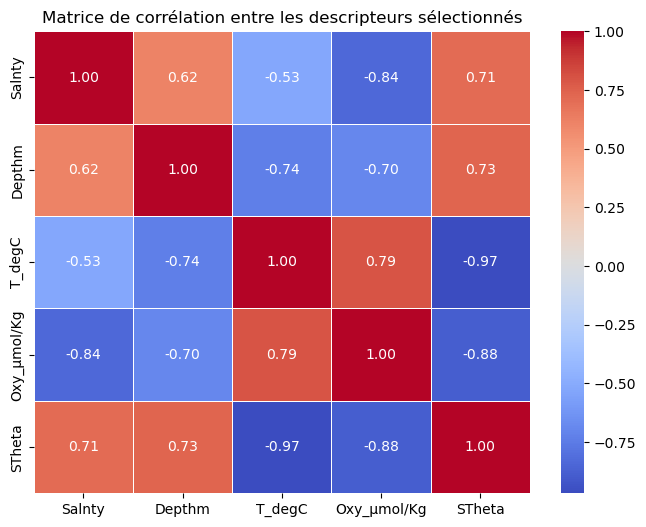

In [10]:
features_ch = ['Salnty', 'Depthm', 'T_degC','Oxy_µmol/Kg','STheta']
correlation_matrix = data_final[features_ch].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice de corrélation entre les descripteurs sélectionnés')
plt.show()

           T_degC      Depthm      Salnty      STheta  Oxy_µmol/Kg
count  300.000000  300.000000  300.000000  300.000000   300.000000
mean     0.386709    0.125565    0.490371    0.609368     0.484917
std      0.194835    0.144198    0.167913    0.220831     0.310833
min      0.000000    0.000000    0.000000    0.000000     0.000000
25%      0.238813    0.029167    0.353166    0.430440     0.189551
50%      0.340183    0.081944    0.513349    0.665286     0.469814
75%      0.523288    0.166667    0.614798    0.783908     0.814026
max      1.000000    1.000000    1.000000    1.000000     1.000000


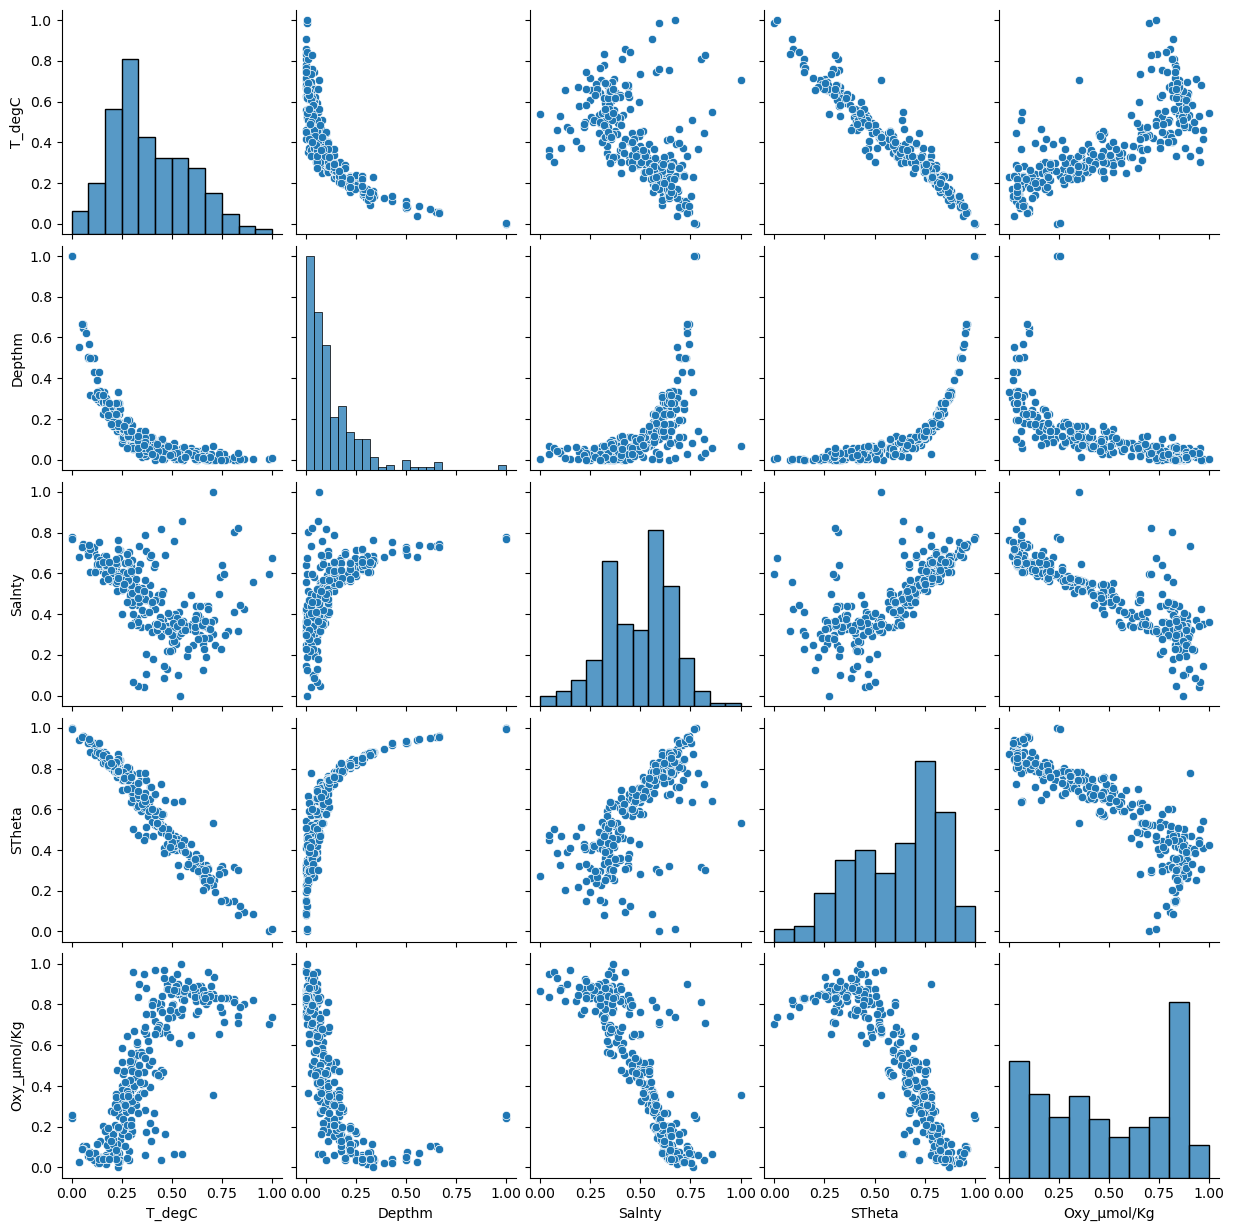

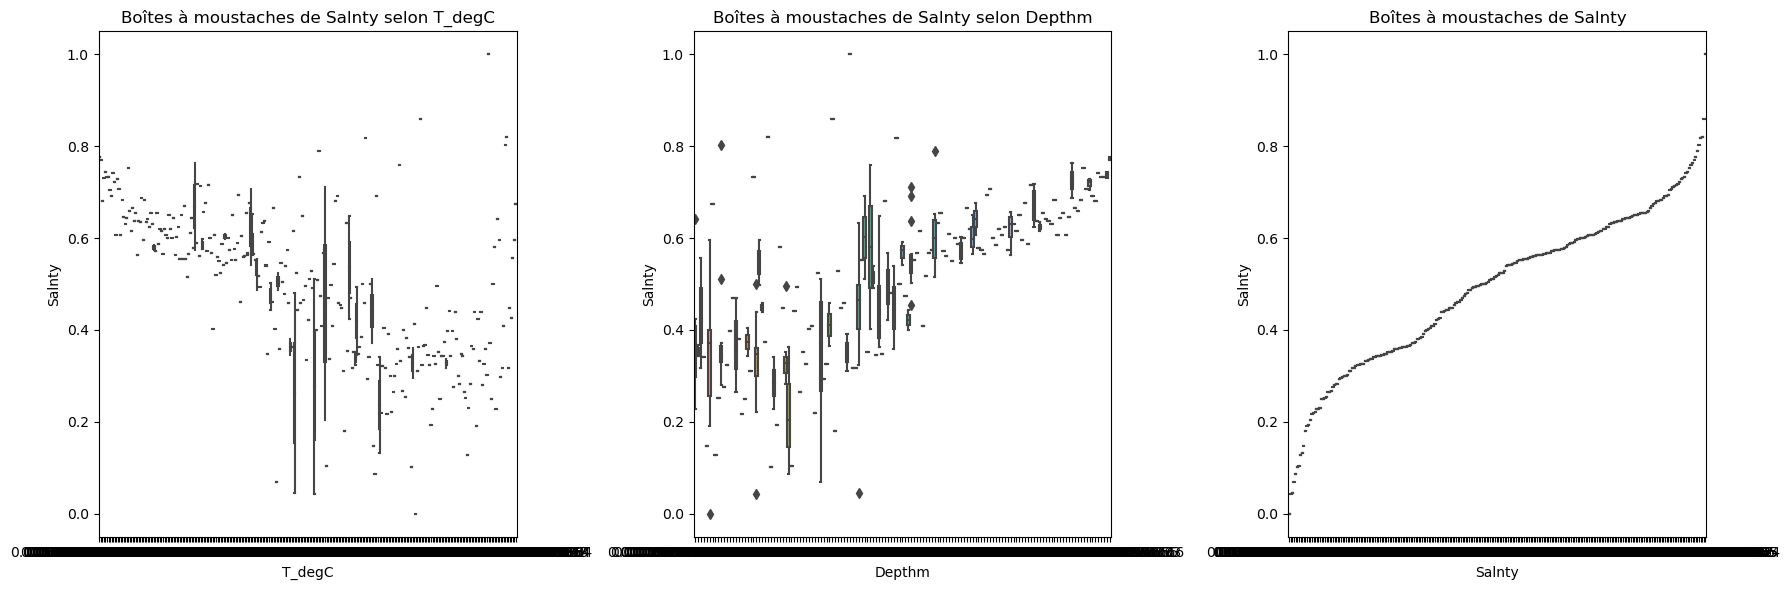

In [11]:
# Statistiques descriptives
descriptive_stats =data_final[['T_degC', 'Depthm','Salnty','STheta','Oxy_µmol/Kg']].describe()
print(descriptive_stats)

# Diagrammes de dispersion
sns.pairplot(data_final[['T_degC', 'Depthm','Salnty','STheta','Oxy_µmol/Kg']])
plt.show()

# Créer une figure et des sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Premier graphique
sns.boxplot(x='T_degC', y='Salnty', data =data_final, ax=axes[0])
axes[0].set_title('Boîtes à moustaches de Salnty selon T_degC')

# Deuxième graphique
sns.boxplot(x='Depthm', y='Salnty', data = data_final, ax=axes[1])
axes[1].set_title('Boîtes à moustaches de Salnty selon Depthm')

# Troisième graphique
sns.boxplot(x='Salnty', y='Salnty', data = data_final, ax=axes[2])
axes[2].set_title('Boîtes à moustaches de Salnty')

# Afficher les graphiques
plt.tight_layout()
plt.show()

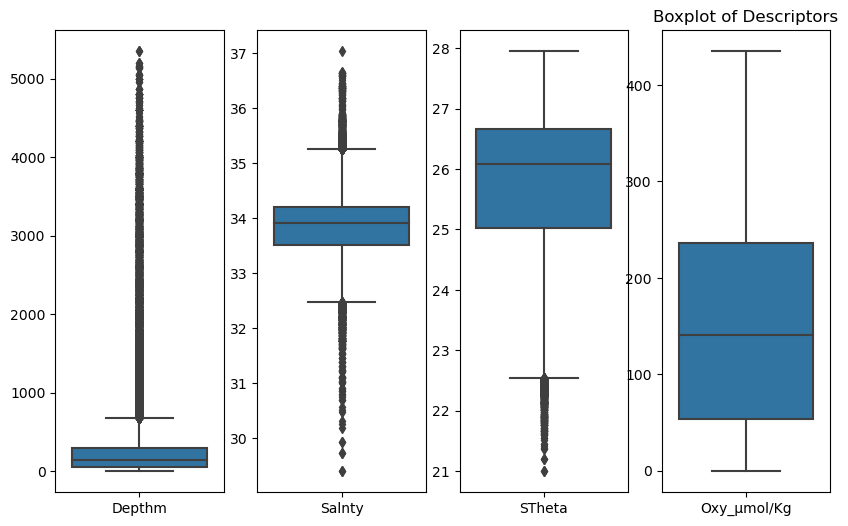

In [12]:
plt.figure(figsize=(10, 6))
plt.subplot(1,4,1)
sns.boxplot(data=tempdata[['Depthm']])
plt.subplot(1,4,2)
sns.boxplot(data=tempdata[['Salnty']])
plt.subplot(1,4,3)
sns.boxplot(data=tempdata[['STheta']])
plt.subplot(1,4,4)
sns.boxplot(data=tempdata[['Oxy_µmol/Kg']])
plt.title('Boxplot of Descriptors')
plt.show()


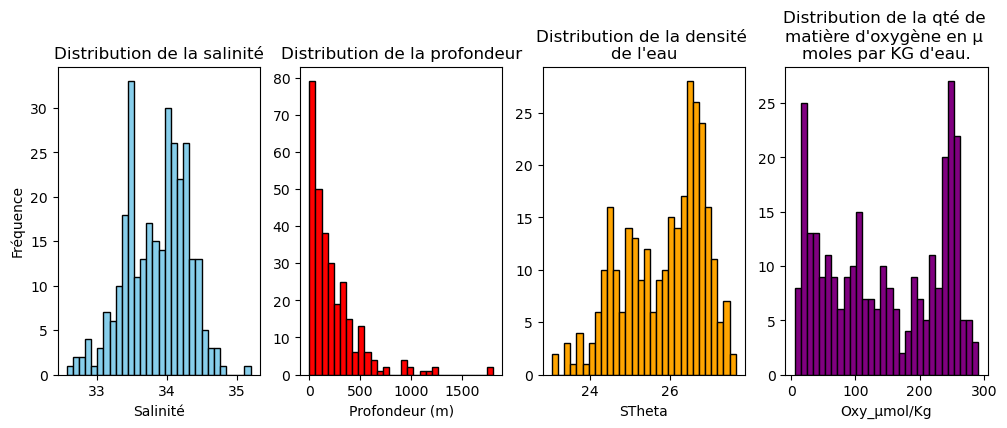

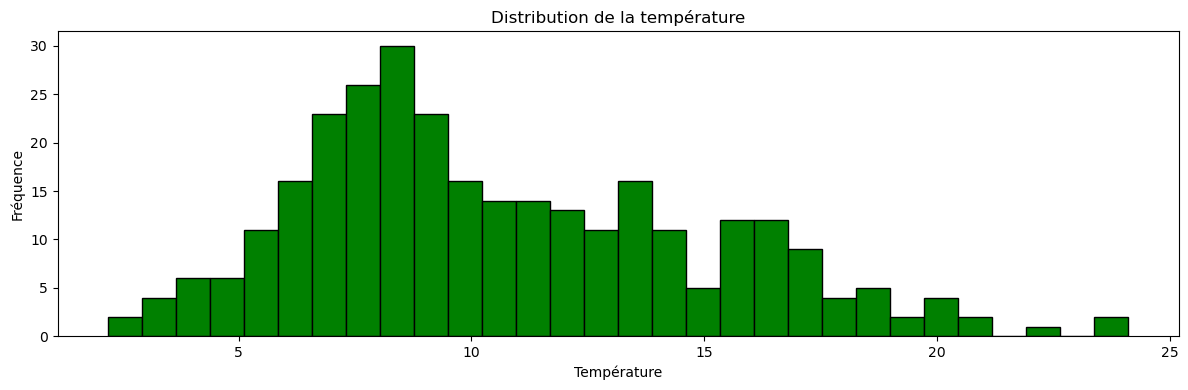

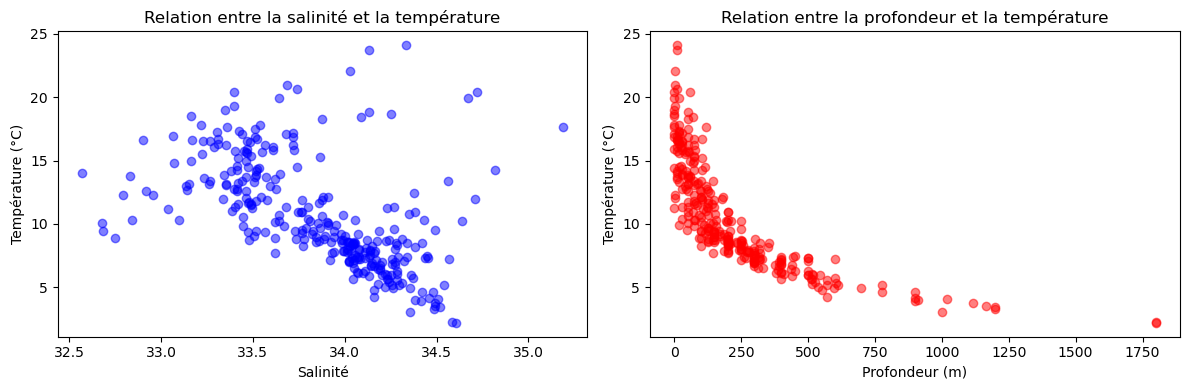

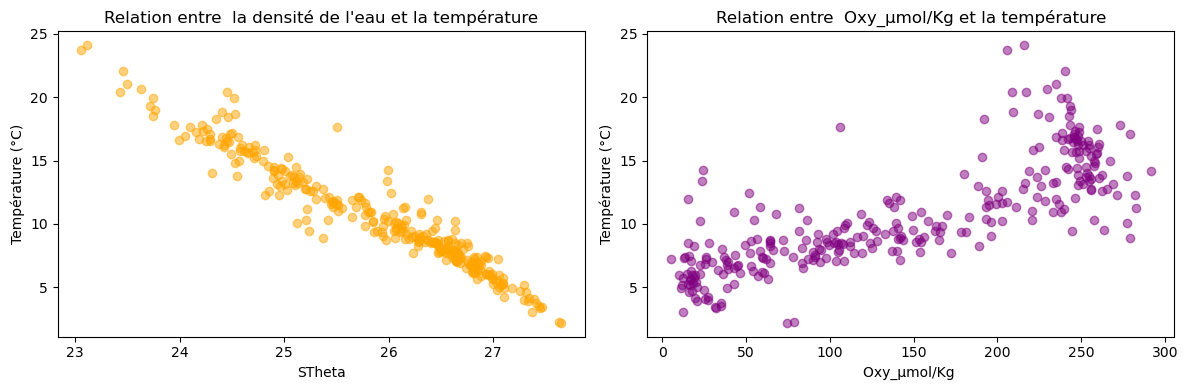

In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.hist(tempdata_imputed_df['Salnty'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution de la salinité')
plt.xlabel('Salinité')
plt.ylabel('Fréquence')

plt.subplot(1, 4, 2)
plt.hist(tempdata_imputed_df['Depthm'], bins=30, color='red', edgecolor='black')
plt.title('Distribution de la profondeur')
plt.xlabel('Profondeur (m)')

plt.subplot(1, 4, 3)
plt.hist(tempdata_imputed_df['STheta'], bins=30, color='orange', edgecolor='black')
plt.title('Distribution de la densité \nde l\'eau')
plt.xlabel('STheta')


plt.subplot(1, 4, 4)
plt.hist(tempdata_imputed_df['Oxy_µmol/Kg'], bins=30, color='purple', edgecolor='black')
plt.title('Distribution de la qté de \nmatière d\'oxygène en µ \nmoles par KG d\'eau.'  )
plt.xlabel('Oxy_µmol/Kg')

plt.figure(figsize=(12, 4))
plt.subplot(1, 1, 1)
plt.hist(tempdata_imputed_df['T_degC'], bins=30, color='green', edgecolor='black')
plt.title('Distribution de la température')
plt.xlabel('Température')
plt.ylabel('Fréquence')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(tempdata_imputed_df['Salnty'], tempdata_imputed_df['T_degC'], alpha=0.5, color='blue')
plt.title('Relation entre la salinité et la température')
plt.xlabel('Salinité')
plt.ylabel('Température (°C)')

plt.subplot(1, 2, 2)
plt.scatter(tempdata_imputed_df['Depthm'], tempdata_imputed_df['T_degC'], alpha=0.5, color='red')
plt.title('Relation entre la profondeur et la température')
plt.xlabel('Profondeur (m)')
plt.ylabel('Température (°C)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(tempdata_imputed_df['STheta'], tempdata_imputed_df['T_degC'], alpha=0.5, color='orange')
plt.title('Relation entre  la densité de l\'eau et la température')
plt.xlabel('STheta')
plt.ylabel('Température (°C)')

plt.subplot(1, 2, 2)
plt.scatter(tempdata_imputed_df['Oxy_µmol/Kg'], tempdata_imputed_df['T_degC'], alpha=0.5, color='purple')
plt.title('Relation entre  Oxy_µmol/Kg et la température')
plt.xlabel('Oxy_µmol/Kg ')
plt.ylabel('Température (°C)')

plt.tight_layout()
plt.show()




# Ingénierie des descripteurs et modélisation 

In [52]:
X = tempdata_imputed_df[[ 'Depthm','Salnty','STheta','Oxy_µmol/Kg']]
y = tempdata_imputed_df['T_degC']  # Variable cible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Régression linéaire

In [21]:
# Créer le modèle de régression linéaire
model = LinearRegression()

In [22]:
# Entraîner le modèle sur l'ensemble d'entraînement
model.fit(X_train, y_train)

LinearRegression()

In [23]:
# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

In [24]:
#Évaluer le modèle
print("\033[91mPrécision de la Régression Linéaire : \033[0m", model.score(X_test, y_test))

Précision de la Régression Linéaire :  0.9951558086328302


## SVM

In [25]:
# Création du modèle SVM pour la régression
svm_regressor = SVR(kernel='linear')

In [26]:
# Entraînement du modèle
svm_regressor.fit(X_train, y_train)

SVR(kernel='linear')

In [27]:
# Prédiction sur l'ensemble de test
y_pred = svm_regressor.predict(X_test)

In [28]:
#Évaluer le modèle
print("\033[91mPrécision du modèle SVM : \033[0m", svm_regressor.score(X_test, y_test))

Précision du modèle SVM :  0.9958181260904557


## Random Forest

In [29]:
# Création du modèle de forêt d'arbres décisionnels
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

In [30]:
# Entraînement du modèle
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [31]:
# Prédiction sur l'ensemble de test
y_pred = rf_regressor.predict(X_test)

In [32]:
#Évaluer le modèle
print("\033[91mPrécision du modèle Random Forest : \033[0m", model.score(X_test, y_test))

Précision du modèle Random Forest :  0.9951558086328302


# Création de nouveaux descripteurs non linéaires à l'aide de la transformation polynomiale avec PolynomialFeatures 

In [33]:
degree = 2  # Degré du polynôme
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Entraîner le modèle
polyreg.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = polyreg.predict(X_test)

#Évaluer le modèle
print("\033[91mPrécision du modèle : \033[0m", polyreg.score(X_test, y_test))

Précision du modèle :  0.9996912456778886


# Evaluation des performance

In [34]:
def evaluate_model(model, X_test, y_test):
    """
    Évalue un modèle en utilisant différentes métriques d'évaluation et affiche les résultats.

    Args:
    - model: Le modèle entraîné à évaluer.
    - X_test (array-like): Les features de l'ensemble de test.
    - y_test (array-like): Les vraies valeurs cibles de l'ensemble de test.
    """
    # Prédire les valeurs sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Calculer les différentes métriques d'évaluation
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    msle = mean_squared_log_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Afficher les résultats
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("Coefficient of Determination (R²):", r2)
    print("Mean Squared Logarithmic Error (MSLE):", msle)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("Mean Absolute Percentage Error (MAPE):", mape)

## PolynomialFeatures 

In [35]:
evaluate_model(polyreg, X_test, y_test)

Mean Squared Error (MSE): 0.006065670749294028
Mean Absolute Error (MAE): 0.04574418630267371
Coefficient of Determination (R²): 0.9996912456778886
Mean Squared Logarithmic Error (MSLE): 4.022492503046577e-05
Root Mean Squared Error (RMSE): 0.07788241617524477
Mean Absolute Percentage Error (MAPE): 0.004649871839846559


 En moyenne, les prédictions du modèle ont une erreur absolue de pourcentage de 0.04%. Cela indique que, en moyenne, les prédictions du modèle s'écartent d'environ 0.04% des vraies valeurs cibles

## Régression linéaire

In [36]:
evaluate_model(model, X_test, y_test)

Mean Squared Error (MSE): 0.09516715322036487
Mean Absolute Error (MAE): 0.23221782557843398
Coefficient of Determination (R²): 0.9951558086328302
Mean Squared Logarithmic Error (MSLE): 0.001956717225564962
Root Mean Squared Error (RMSE): 0.3084917393065248
Mean Absolute Percentage Error (MAPE): 0.03064506323742546


 En moyenne, les prédictions du modèle ont une erreur absolue de pourcentage de 0.3%. Cela indique que, en moyenne, les prédictions du modèle s'écartent d'environ 0.3% des vraies valeurs cibles

## SVM

In [37]:
evaluate_model(svm_regressor, X_test, y_test)

Mean Squared Error (MSE): 0.08215551470468876
Mean Absolute Error (MAE): 0.20997520868557987
Coefficient of Determination (R²): 0.9958181260904557
Mean Squared Logarithmic Error (MSLE): 0.0016467458041189852
Root Mean Squared Error (RMSE): 0.286627833094919
Mean Absolute Percentage Error (MAPE): 0.027756858192252567


En moyenne, les prédictions du modèle ont une erreur absolue de pourcentage de 0.2%. Cela indique que, en moyenne, les prédictions du modèle s'écartent d'environ 0.2% des vraies valeurs cibles

## Random Forest

In [38]:
evaluate_model(rf_regressor, X_test, y_test)

Mean Squared Error (MSE): 0.29472175255333355
Mean Absolute Error (MAE): 0.34907366666666667
Coefficient of Determination (R²): 0.984998095234286
Mean Squared Logarithmic Error (MSLE): 0.0027249522503875884
Root Mean Squared Error (RMSE): 0.5428828165942753
Mean Absolute Percentage Error (MAPE): 0.03759549016944988
